In [1]:
# Build gallery-style JSON from annos (with category_id)
import os
import json
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import models, transforms
import faiss
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import random

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(43)
torch.manual_seed(43)
np.random.seed(43)

class FashionRetrievalModel(nn.Module):
    def __init__(self, embedding_dim=512):
        super().__init__()
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        num_ftrs = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        self.embedding = nn.Sequential(
            nn.Linear(num_ftrs, embedding_dim),
            nn.BatchNorm1d(embedding_dim)
        )

    def forward(self, x):
        features = self.backbone(x)
        return F.normalize(self.embedding(features), p=2, dim=1)

# Triplet Dataset
class TripletFashionDataset(torch.utils.data.Dataset):
    def __init__(self, image_folder, annotation_path, annos_folder, transform):
        self.image_folder = image_folder
        self.annotation_path = annotation_path
        self.annos_folder = annos_folder
        self.transform = transform

        print(f"📂 Loading annotations from: {annotation_path}")
        with open(annotation_path) as f:
            self.data = json.load(f)

        self.category_to_images = {}
        for item in self.data:
            gallery_id = item.get("gallery_image_id")
            pair_id = item.get("pair_id")
            if gallery_id is not None and pair_id is not None:
                file_name = f"{gallery_id:06d}.jpg"
                full_path = os.path.join(image_folder, file_name)
                if os.path.isfile(full_path):
                    self.category_to_images.setdefault(pair_id, []).append(file_name)

        self.image_triplets = self._generate_triplets()
        print(f"✅ Triplets generated: {len(self.image_triplets)}")

    def _load_and_crop(self, filename):
        img_path = os.path.join(self.image_folder, filename)
        ann_path = os.path.join(self.annos_folder, filename.replace('.jpg', '.json'))
        img = Image.open(img_path).convert("RGB")
        if os.path.isfile(ann_path):
            with open(ann_path) as f:
                ann = json.load(f)
                if "bounding_box" in ann:
                    x, y, w, h = ann["bounding_box"]
                    img = img.crop((x, y, x + w, y + h))
        return img

    def _generate_triplets(self):
        triplets = []
        categories = list(self.category_to_images.keys())
        for cat in categories:
            imgs = self.category_to_images[cat]
            if len(imgs) < 2:
                continue
            for i in range(len(imgs) - 1):
                anchor = imgs[i]
                positive = imgs[i + 1]
                neg_cat = random.choice([c for c in categories if c != cat and len(self.category_to_images[c]) > 0])
                negative = self.category_to_images[neg_cat][0]
                triplets.append((anchor, positive, negative))
        return triplets

    def __len__(self):
        return len(self.image_triplets)

    def __getitem__(self, idx):
        a, p, n = self.image_triplets[idx]
        a_img = self._load_and_crop(a)
        p_img = self._load_and_crop(p)
        n_img = self._load_and_crop(n)
        if self.transform:
            a_img = self.transform(a_img)
            p_img = self.transform(p_img)
            n_img = self.transform(n_img)
        return a_img, p_img, n_img

# Training loop

def train(model, dataloader, optimizer, criterion, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for i, (anchor, positive, negative) in enumerate(dataloader):
            anchor, positive, negative = anchor.to(DEVICE), positive.to(DEVICE), negative.to(DEVICE)
            a_embed = model(anchor)
            p_embed = model(positive)
            n_embed = model(negative)

            loss = criterion(a_embed, p_embed, n_embed)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            if i % 10 == 0:
                print(f"Epoch {epoch+1} | Batch {i}/{len(dataloader)} | Loss: {loss.item():.4f}")

        avg_loss = total_loss / len(dataloader)
        print(f"✅ Epoch {epoch+1} complete | Avg Loss: {avg_loss:.4f}")


In [2]:
image_folder = "validation/validation/image"
annotation_path = "val_annotations/json_for_validation/val_gallery.json"
annos_folder = "validation/validation/annos"

train_dataset = TripletFashionDataset(image_folder, annotation_path, annos_folder, transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

model = FashionRetrievalModel().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.TripletMarginLoss(margin=0.3)

train(model, train_loader, optimizer, criterion, epochs=10)


📂 Loading annotations from: val_annotations/json_for_validation/val_gallery.json
✅ Triplets generated: 34682
Epoch 1 | Batch 0/1084 | Loss: 0.0417
Epoch 1 | Batch 10/1084 | Loss: 0.0359
Epoch 1 | Batch 20/1084 | Loss: 0.0240
Epoch 1 | Batch 30/1084 | Loss: 0.0382
Epoch 1 | Batch 40/1084 | Loss: 0.0383
Epoch 1 | Batch 50/1084 | Loss: 0.0226
Epoch 1 | Batch 60/1084 | Loss: 0.0320
Epoch 1 | Batch 70/1084 | Loss: 0.0152
Epoch 1 | Batch 80/1084 | Loss: 0.0118
Epoch 1 | Batch 90/1084 | Loss: 0.0131
Epoch 1 | Batch 100/1084 | Loss: 0.0227
Epoch 1 | Batch 110/1084 | Loss: 0.0045
Epoch 1 | Batch 120/1084 | Loss: 0.0629
Epoch 1 | Batch 130/1084 | Loss: 0.0210
Epoch 1 | Batch 140/1084 | Loss: 0.0029
Epoch 1 | Batch 150/1084 | Loss: 0.0192
Epoch 1 | Batch 160/1084 | Loss: 0.0188
Epoch 1 | Batch 170/1084 | Loss: 0.0225
Epoch 1 | Batch 180/1084 | Loss: 0.0131
Epoch 1 | Batch 190/1084 | Loss: 0.0005
Epoch 1 | Batch 200/1084 | Loss: 0.0350
Epoch 1 | Batch 210/1084 | Loss: 0.0088
Epoch 1 | Batch 220/10

In [26]:
# Build FAISS index using validation data with bounding box crop and category mapping

def crop_and_embed(image_path, annos_folder, model):
    img = Image.open(image_path).convert("RGB")
    ann_path = os.path.join(annos_folder, os.path.basename(image_path).replace('.jpg', '.json'))
    if os.path.isfile(ann_path):
        with open(ann_path) as f:
            ann = json.load(f)
            if "bounding_box" in ann:
                x, y, w, h = ann["bounding_box"]
                img = img.crop((x, y, x + w, y + h))
    img = transform(img).unsqueeze(0).to(DEVICE)
    model.eval()
    with torch.no_grad():
        return model(img).cpu().numpy()

def build_faiss_index(image_folder, annos_folder, json_path, model):
    index = faiss.IndexFlatL2(512)
    image_paths = []
    labels = []
    with open(json_path) as f:
        data = json.load(f)

    for entry in data:
        file = f"{entry['gallery_image_id']:06d}.jpg"
        full_path = os.path.join(image_folder, file)
        ann_path = os.path.join(annos_folder, file.replace(".jpg", ".json"))
        if os.path.isfile(full_path) and os.path.isfile(ann_path):
            emb = crop_and_embed(full_path, annos_folder, model)
            index.add(emb)
            image_paths.append(full_path)

            try:
                with open(ann_path) as f_ann:
                    ann_data = json.load(f_ann)
                    categories = []
                    for key, item in ann_data.items():
                        if key.startswith("item") and "category_name" in item:
                            categories.append(item["category_name"])
                    if categories:
                        labels.append(", ".join(categories))
                    else:
                        labels.append("Unknown")
            except:
                labels.append("Unknown")
    return index, image_paths, labels


In [27]:
# Retrieve and show categories (with duplicate filtering)
def retrieve_similar(query_image_path, index, image_paths, labels, annos_folder, top_k=5):
    def crop_and_embed_for_query(img_path):
        img = Image.open(img_path).convert("RGB")
        ann_path = os.path.join(annos_folder, os.path.basename(img_path).replace(".jpg", ".json"))
        if os.path.isfile(ann_path):
            with open(ann_path) as f:
                ann = json.load(f)
                if "bounding_box" in ann:
                    x, y, w, h = ann["bounding_box"]
                    img = img.crop((x, y, x + w, y + h))
        img = transform(img).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            return model(img).cpu().numpy()

    query_emb = crop_and_embed_for_query(query_image_path)
    D, I = index.search(query_emb, top_k * 2)  

    seen = set()
    filtered_results = []
    for i, d in zip(I[0], D[0]):
        fname = os.path.basename(image_paths[i])
        if fname not in seen:
            seen.add(fname)
            filtered_results.append((image_paths[i], d, labels[i]))
        if len(filtered_results) == top_k:
            break

    print(f"\n🧥 Query: {os.path.basename(query_image_path)}")
    print("Top matches:")
    for rank, (path, dist, cat) in enumerate(filtered_results):
        print(f"{rank+1}. {os.path.basename(path)} | Distance: {dist:.4f} | Category: {cat}")

    return [path for path, _, _ in filtered_results], [dist for _, dist, _ in filtered_results]


In [28]:
def visualize_results(query_path, result_paths):
    import matplotlib.pyplot as plt
    from PIL import Image

    plt.figure(figsize=(15, 3))
    query_img = Image.open(query_path).convert("RGB")
    plt.subplot(1, len(result_paths) + 1, 1)
    plt.imshow(query_img)
    plt.title("Query")
    plt.axis("off")
    
    for i, path in enumerate(result_paths):
        img = Image.open(path).convert("RGB")
        plt.subplot(1, len(result_paths) + 1, i + 2)
        plt.imshow(img)
        plt.title(f"Result {i+1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()



🧥 Query: 010845.jpg
Top matches:
1. 010845.jpg | Distance: 0.0000 | Category: sling dress, vest
2. 010848.jpg | Distance: 0.1644 | Category: vest, sling dress
3. 010849.jpg | Distance: 0.2461 | Category: vest, sling dress
4. 010847.jpg | Distance: 0.3043 | Category: sling dress, vest
5. 010852.jpg | Distance: 0.3132 | Category: sling dress, vest


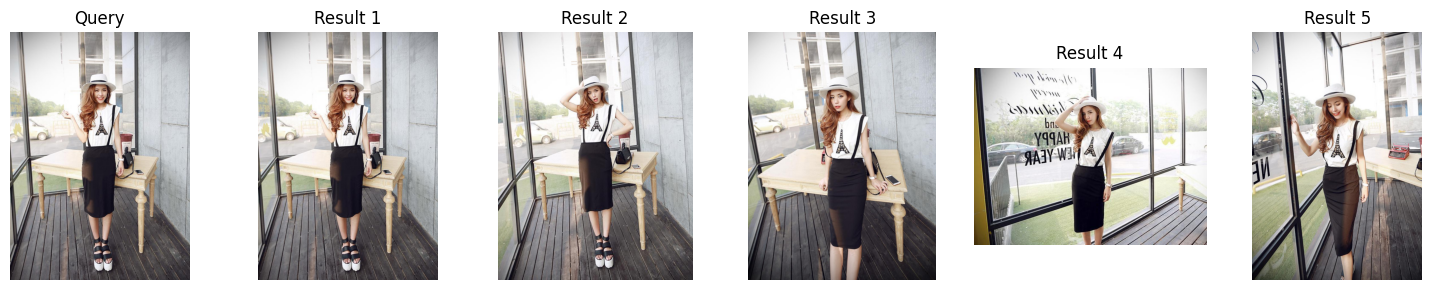

In [29]:
image_folder = "validation/validation/image"
annos_folder = "validation/validation/annos"
json_path = "val_annotations/json_for_validation/val_gallery.json"

index, image_paths, labels = build_faiss_index(image_folder, annos_folder, json_path, model)


query_path = image_paths[0]


result_paths, distances = retrieve_similar(query_path, index, image_paths, labels, annos_folder, top_k=5)


visualize_results(query_path, result_paths)



🧥 Query: 011074.jpg
Top matches:
1. 011074.jpg | Distance: 0.0000 | Category: vest, skirt
2. 011078.jpg | Distance: 0.0329 | Category: skirt, vest
3. 011080.jpg | Distance: 0.1339 | Category: skirt, vest
4. 011077.jpg | Distance: 0.1859 | Category: skirt, vest
5. 011079.jpg | Distance: 0.2605 | Category: skirt, vest


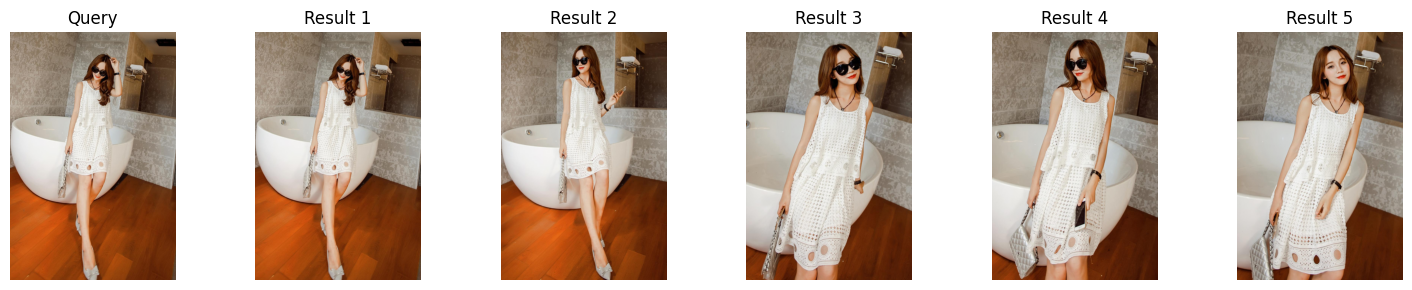

In [30]:
image_folder = "validation/validation/image"
annos_folder = "validation/validation/annos"
json_path = "val_annotations/json_for_validation/val_gallery.json"

index, image_paths, labels = build_faiss_index(image_folder, annos_folder, json_path, model)


query_path = image_paths[400]


result_paths, distances = retrieve_similar(query_path, index, image_paths, labels, annos_folder, top_k=5)


visualize_results(query_path, result_paths)



🧥 Query: TestingImage.jpg
Top matches:
1. 017673.jpg | Distance: 0.4294 | Category: skirt, long sleeve top
2. 017675.jpg | Distance: 0.4399 | Category: skirt, long sleeve top
3. 028524.jpg | Distance: 0.4497 | Category: short sleeve top
4. 017676.jpg | Distance: 0.4562 | Category: skirt, long sleeve top
5. 025797.jpg | Distance: 0.4599 | Category: trousers, long sleeve top


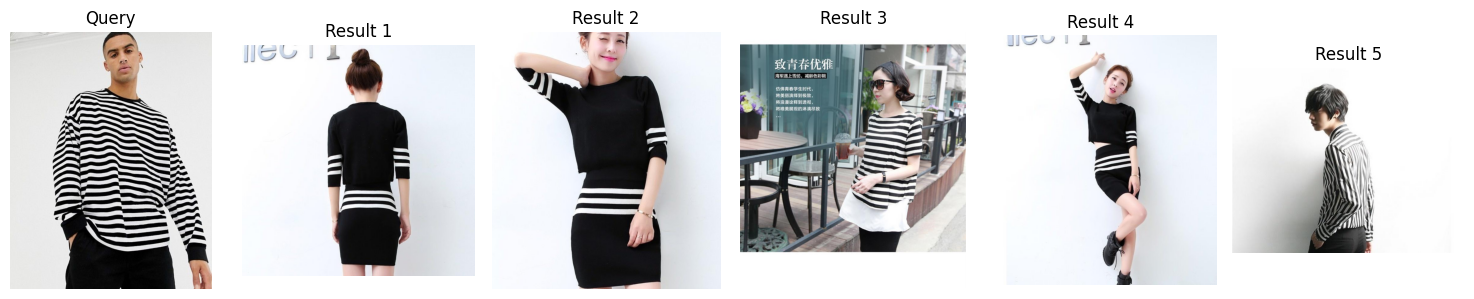

In [31]:
image_folder = "validation/validation/image"
annos_folder = "validation/validation/annos"
json_path = "val_annotations/json_for_validation/val_gallery.json"

index, image_paths, labels = build_faiss_index(image_folder, annos_folder, json_path, model)


query_path =  "TestingImage.jpg"


result_paths, distances = retrieve_similar(query_path, index, image_paths, labels, annos_folder, top_k=5)


visualize_results(query_path, result_paths)



🧥 Query: TestingImage3.jpg
Top matches:
1. 031889.jpg | Distance: 0.5967 | Category: trousers, long sleeve top
2. 026866.jpg | Distance: 0.6057 | Category: trousers, short sleeve top
3. 021190.jpg | Distance: 0.6111 | Category: trousers, long sleeve top
4. 026071.jpg | Distance: 0.6126 | Category: trousers
5. 026289.jpg | Distance: 0.6401 | Category: trousers, long sleeve top


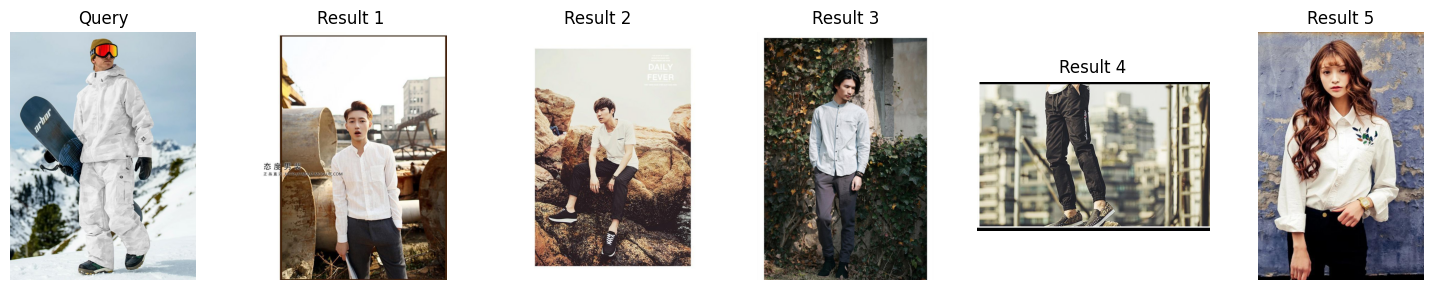

In [33]:
image_folder = "validation/validation/image"
annos_folder = "validation/validation/annos"
json_path = "val_annotations/json_for_validation/val_gallery.json"

index, image_paths, labels = build_faiss_index(image_folder, annos_folder, json_path, model)


query_path =  "TestingImage3.jpg"


result_paths, distances = retrieve_similar(query_path, index, image_paths, labels, annos_folder, top_k=5)


visualize_results(query_path, result_paths)
